In [35]:
pip install datasets sacremoses

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [38]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from transformers import BertTokenizer

# ds = load_dataset("stanfordnlp/imdb")
# BERT 토크나이저 로드
# torch.hub.load를 사용하여 transformers 모델이나 토크나이저를 불러오는 방식이 더 이상 지원X
#tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# collate_fn 수정
# def collate_fn(batch):
#   max_len = 400
#   texts, labels = [], []
#   for row in batch:
#     labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
#     texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

#   texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
#   labels = torch.LongTensor(labels)

  # return texts, labels

# 데이터셋 로드
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

# Collate function 정의
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

# DataLoader 정의
train_loader = DataLoader(ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn) #train mode
test_loader = DataLoader(ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn) #test mode


In [39]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

In [40]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [41]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [42]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

In [43]:
from torch.optim import Adam

device = torch.device('mps')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=0.01)

def calculate_accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [46]:
num_epochs = 10
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
  total_loss = 0.
  model.train()  # 학습

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = calculate_accuracy(model, train_loader)  # 학습데이터 정확도
    test_acc = calculate_accuracy(model, test_loader)    # 테스트데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   2 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   3 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   4 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   5 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   6 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   7 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   8 | Train Acc: 0.000 | Test Acc: 0.000
Epoch   9 | Train Acc: 0.000 | Test Acc: 0.000
Epoch  10 | Train Acc: 0.000 | Test Acc: 0.000


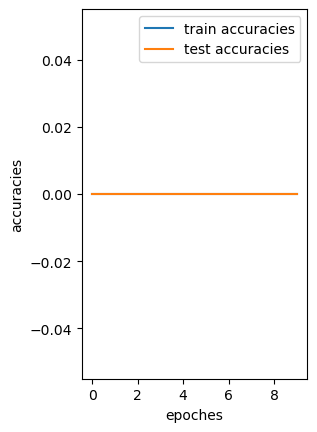

In [47]:
from matplotlib import pyplot as plt

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='train accuracies')
plt.plot(range(num_epochs), test_accuracies, label='test accuracies')
plt.xlabel('epoches')
plt.ylabel('accuracies')
plt.legend()
plt.show()

# plot_acc(train_accuracies, test_accuracies)